In [1]:
"""Should use Gaussian low pass filter and k-means segmentation
Convert r g b into separate channels and convert to Lab color space
Evaluation metrics le accuracy , dice coefficient, entropy and one more
Psnr and ssim
Shud do all these for a drone captured image under cloudy weather conditions"""

'Should use Gaussian low pass filter and k-means segmentation\nConvert r g b into separate channels and convert to Lab color space\nEvaluation metrics le accuracy , dice coefficient, entropy\xa0and\xa0one\xa0more\nPsnr and ssim\nShud do all these for a drone captured image under cloudy weather\xa0conditions'

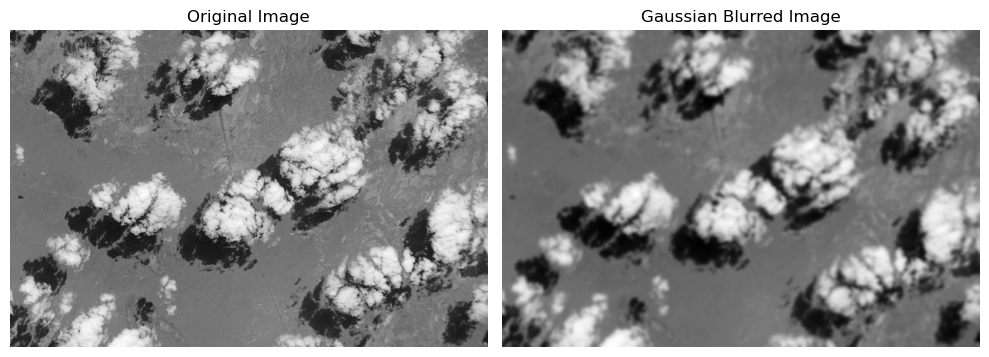

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image in grayscale
image_path = r"C:\Users\onlyh\Downloads\sat1.jpg"  # Replace with your image file path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image loaded successfully
if img is None:
    raise ValueError("Image not found or path is incorrect")

# Apply Gaussian Low-Pass Filter
# kernel size (15x15), sigmaX=0 lets OpenCV auto-select based on kernel size
blurred_img = cv2.GaussianBlur(img, (15, 15), 0)

# Show the results using matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Gaussian Blurred Image')
plt.imshow(blurred_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


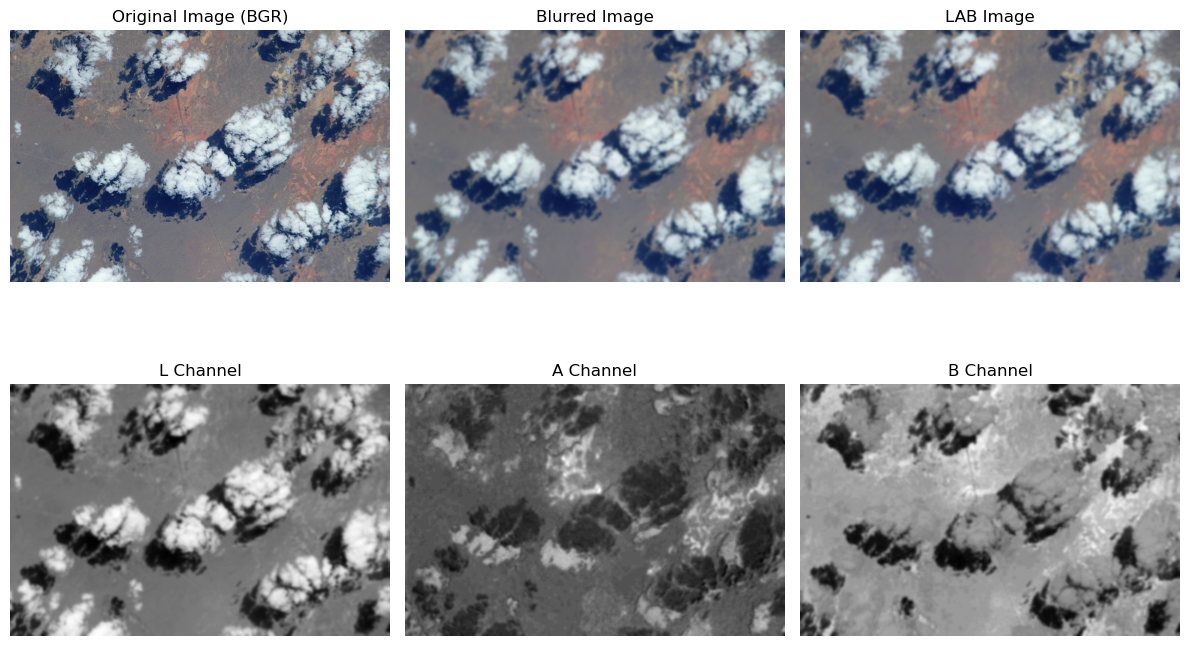

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image in color (BGR format)
image_path = r"C:\Users\onlyh\Downloads\sat1.jpg"  # Replace with your image file path
img = cv2.imread(image_path)

# Check if image is loaded
if img is None:
    raise ValueError("Image not found. Check the image path.")

# Apply Gaussian Blur to the color image
blurred_img = cv2.GaussianBlur(img, (15, 15), 0)

# Convert the blurred image to LAB color space
lab_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2LAB)

# Split LAB channels
L, A, B = cv2.split(lab_img)

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("Original Image (BGR)")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Blurred Image")
plt.imshow(cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("LAB Image")
plt.imshow(cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB))
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("L Channel")
plt.imshow(L, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("A Channel")
plt.imshow(A, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("B Channel")
plt.imshow(B, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


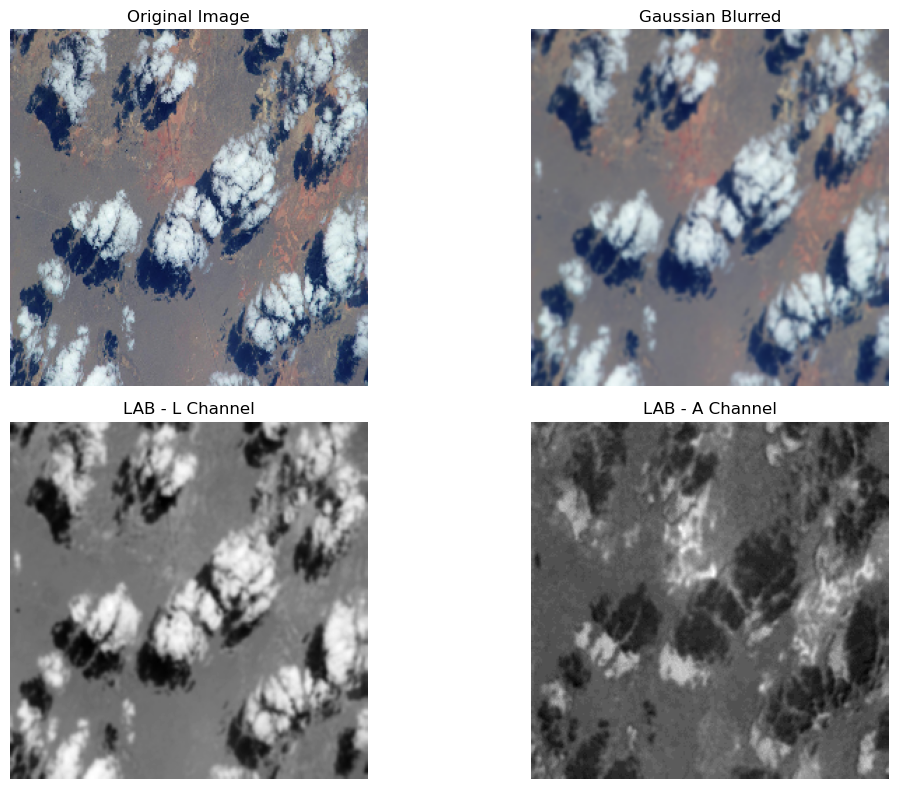

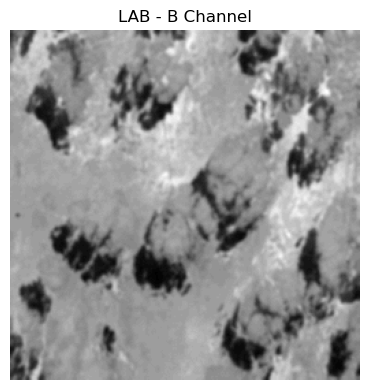

Accuracy: 0.1294
Dice Coefficient: 0.2218
Entropy: 0.5425
PSNR: 0.60 dB
SSIM: -0.1231


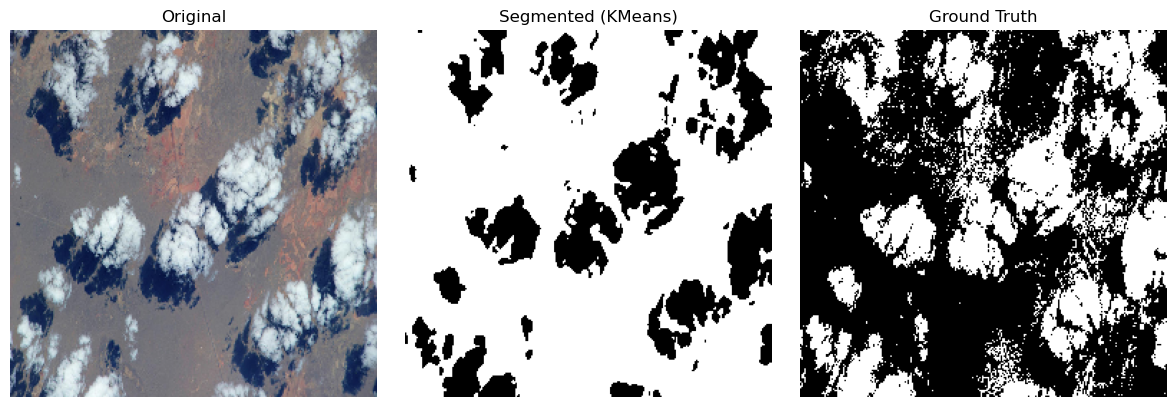

In [16]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from scipy.stats import entropy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1. Load and preprocess image
img = cv2.imread(r"C:\Users\onlyh\Downloads\sat1.jpg")
img = cv2.resize(img, (256, 256))

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Convert to LAB
lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab)  # Separate L, A, B channels
pixels = lab.reshape((-1, 3)).astype(np.float32)

# Show Gaussian Blurred Image and LAB Channels
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Gaussian Blurred")
plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("LAB - L Channel")
plt.imshow(L, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("LAB - A Channel")
plt.imshow(A, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Display B channel separately
plt.figure(figsize=(4, 4))
plt.title("LAB - B Channel")
plt.imshow(B, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Custom K-Means (k=2)
def custom_kmeans(X, k=2, max_iters=10):
    n_samples, n_features = X.shape
    rng = np.random.default_rng(42)
    centers = X[rng.choice(n_samples, k, replace=False)]

    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, None] - centers[None, :], axis=2)
        labels = np.argmin(distances, axis=1)

        new_centers = np.array([X[labels == j].mean(axis=0) if np.any(labels == j) else centers[j]
                                for j in range(k)])
        if np.allclose(centers, new_centers):
            break
        centers = new_centers

    return labels, centers

labels, centers = custom_kmeans(pixels, k=2)
segmented = labels.reshape((256, 256)).astype(np.uint8) * 255

# 3. Normalize segmented image
segmented = cv2.normalize(segmented, None, 0, 255, cv2.NORM_MINMAX)

# 4. Simulated ground truth from grayscale thresholding
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, ground_truth = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Convert to binary masks
seg_bin = (segmented > 127).astype(np.uint8)
gt_bin = (ground_truth > 127).astype(np.uint8)

# 5. Evaluation metrics
accuracy = accuracy_score(gt_bin.flatten(), seg_bin.flatten())
intersection = np.sum(seg_bin * gt_bin)
dice = (2. * intersection) / (np.sum(seg_bin) + np.sum(gt_bin))
seg_entropy = entropy(np.histogram(seg_bin.flatten(), bins=2)[0])
psnr_val = psnr(ground_truth, segmented)
ssim_val = ssim(ground_truth, segmented)

# 6. Output
print(f"Accuracy: {accuracy:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Entropy: {seg_entropy:.4f}")
print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")

# 7. Visualization of segmentation
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Segmented (KMeans)")
plt.imshow(segmented, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap="gray")
plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
"""# Multi-Stage Image processing pipeline : Denoising, Edge Detection, & Region Growing

# Apply Gaussian filtering to remove Laplacian filters
# Detect edges using Canny and Laplacian filters
# Perform region growing segmentation

]

# Evaluation Measures:
# Noise removal success - PSNR
# Edge DEtection Precision - Precision-Recall Curve
# Region Growing Segmentation - Rand Index
# Pipeline Efficiency - Computational Complexity"""

'# Multi-Stage Image processing pipeline : Denoising, Edge Detection, & Region Growing\n\n# Apply Gaussian filtering to remove Laplacian filters\n# Detect edges using Canny and Laplacian filters\n# Perform region growing segmentation\n\n]\n\n# Evaluation Measures:\n# Noise removal success - PSNR\n# Edge DEtection Precision - Precision-Recall Curve\n# Region Growing Segmentation - Rand Index\n# Pipeline Efficiency - Computational Complexity'

In [18]:
"""✅ What Actually Happens:
Laplacian Filter is a high-pass filter used to detect edges. It enhances noise too.

Gaussian Filter is a low-pass filter used to remove high-frequency noise — not Laplacian filters, but the noise they might emphasize.

So a more accurate version of the comment would be:

python
Copy
Edit
# Apply Gaussian filtering to suppress high-frequency noise before edge detection
"""

'✅ What Actually Happens:\nLaplacian Filter is a high-pass filter used to detect edges. It enhances noise too.\n\nGaussian Filter is a low-pass filter used to remove high-frequency noise — not Laplacian filters, but the noise they might emphasize.\n\nSo a more accurate version of the comment would be:\n\npython\nCopy\nEdit\n# Apply Gaussian filtering to suppress high-frequency noise before edge detection\n'

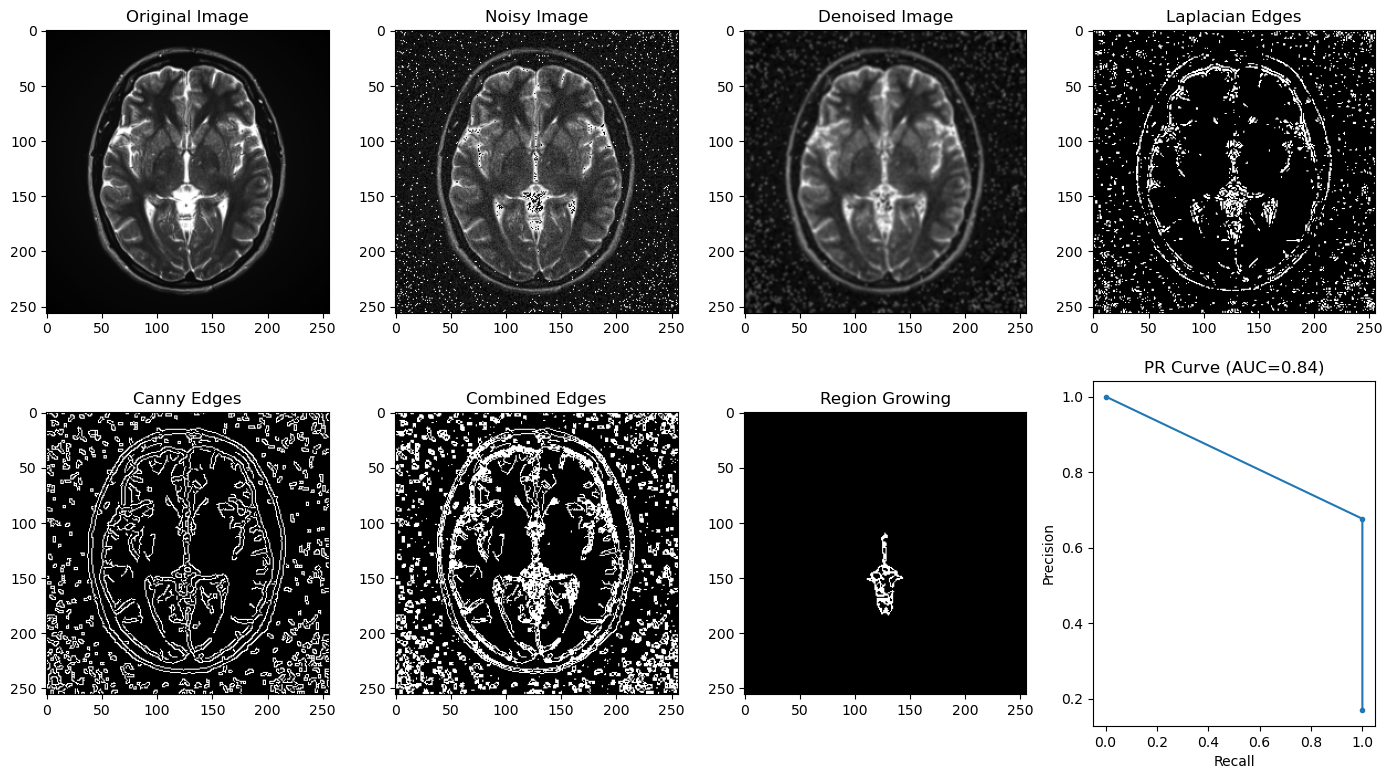


🔍 Evaluation Summary:
✔️ PSNR (Noise Removal Success): 23.09 dB
✔️ Precision-Recall AUC (Edge Detection): 0.84
✔️ Rand Index (Region Segmentation): 0.72
✔️ Pipeline Execution Time: 0.25 seconds


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, rand_score
import time

# ------------------- Stage 1: Load and Preprocess Image -------------------
start_time = time.time()

image = cv2.imread(r"C:\Users\onlyh\Downloads\mri.jpg")  # Use your uploaded image path
image = cv2.resize(image, (256, 256))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_norm = cv2.normalize(gray.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# Add synthetic noise (for testing denoising performance)
noisy = gray + np.random.normal(0, 10, gray.shape).astype(np.uint8)
noisy = np.clip(noisy, 0, 255).astype(np.uint8)

# Denoising
denoised = cv2.GaussianBlur(noisy, (5, 5), 0)

# ------------------- PSNR for Noise Removal Success -------------------
def compute_psnr(original, denoised):
    mse = np.mean((original.astype(np.float32) - denoised.astype(np.float32)) ** 2)
    if mse == 0:
        return 100
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr

psnr_value = compute_psnr(gray, denoised)

# ------------------- Stage 2: Edge Detection -------------------
edges_canny = cv2.Canny(denoised, 50, 150)

laplacian = cv2.Laplacian(denoised, cv2.CV_64F)
laplacian = np.uint8(np.absolute(laplacian))
_, edges_laplacian_bin = cv2.threshold(laplacian, 20, 255, cv2.THRESH_BINARY)

edges_canny = cv2.resize(edges_canny, (256, 256))
edges_laplacian_bin = cv2.resize(edges_laplacian_bin, (256, 256))

combined_edges = cv2.bitwise_or(edges_canny, edges_laplacian_bin)

# ------------------- Stage 3: Region Growing Segmentation -------------------
def region_growing(img, seed, threshold=0.1):
    h, w = img.shape
    segmented = np.zeros((h, w), np.uint8)
    visited = np.zeros((h, w), np.uint8)
    stack = [seed]
    seg_val = img[seed]
    while stack:
        x, y = stack.pop()
        if visited[x, y] == 0 and abs(int(img[x, y]) - int(seg_val)) < threshold * 255:
            segmented[x, y] = 255
            visited[x, y] = 1
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < h and 0 <= ny < w:
                        stack.append((nx, ny))
    return segmented

seed_point = (128, 128)
seg_result = region_growing(denoised, seed_point)

# ------------------- Precision-Recall for Edge Detection -------------------
gt_edges = (edges_canny > 0).astype(int).flatten()
pred_edges = (combined_edges > 0).astype(int).flatten()

precision, recall, _ = precision_recall_curve(gt_edges, pred_edges, pos_label=1)
pr_auc = auc(recall, precision)

# ------------------- Rand Index for Region Growing -------------------
# Ground truth: edges_canny (assuming it as boundary), Prediction: seg_result
# Convert to label form for rand_score
gt_labels = (edges_canny > 0).astype(int).flatten()
seg_labels = (seg_result > 0).astype(int).flatten()
rand_index = rand_score(gt_labels, seg_labels)

# ------------------- Efficiency: Execution Time -------------------
exec_time = time.time() - start_time

# ------------------- Stage 4: Visualization -------------------
plt.figure(figsize=(14, 8))

plt.subplot(2, 4, 1)
plt.title("Original Image")
plt.imshow(gray, cmap='gray')

plt.subplot(2, 4, 2)
plt.title("Noisy Image")
plt.imshow(noisy, cmap='gray')

plt.subplot(2, 4, 3)
plt.title("Denoised Image")
plt.imshow(denoised, cmap='gray')

plt.subplot(2, 4, 4)
plt.title("Laplacian Edges")
plt.imshow(edges_laplacian_bin, cmap='gray')

plt.subplot(2, 4, 5)
plt.title("Canny Edges")
plt.imshow(edges_canny, cmap='gray')

plt.subplot(2, 4, 6)
plt.title("Combined Edges")
plt.imshow(combined_edges, cmap='gray')

plt.subplot(2, 4, 7)
plt.title("Region Growing")
plt.imshow(seg_result, cmap='gray')

plt.subplot(2, 4, 8)
plt.title(f"PR Curve (AUC={pr_auc:.2f})")
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

# ------------------- Final Evaluation Report -------------------
print("\n🔍 Evaluation Summary:")
print(f"✔️ PSNR (Noise Removal Success): {psnr_value:.2f} dB")
print(f"✔️ Precision-Recall AUC (Edge Detection): {pr_auc:.2f}")
print(f"✔️ Rand Index (Region Segmentation): {rand_index:.2f}")
print(f"✔️ Pipeline Execution Time: {exec_time:.2f} seconds")


In [ ]:
#kmeans

PSNR between original and clustered image: 28.15 dB


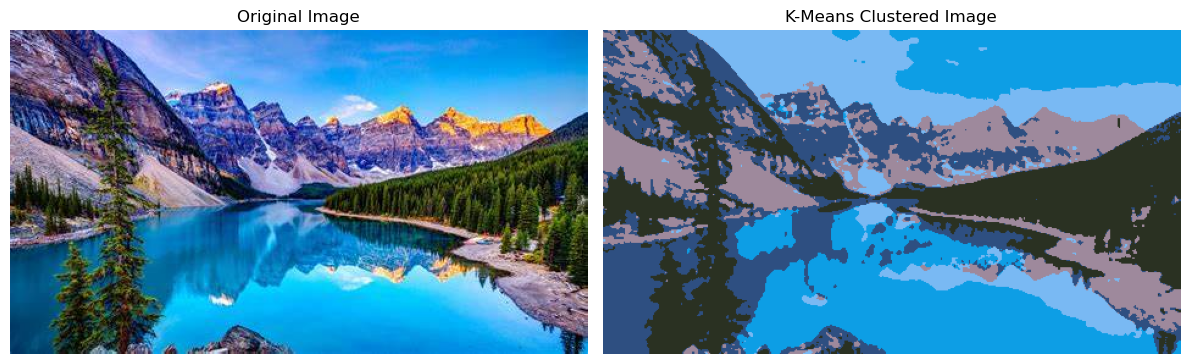

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ------------------- Load Image -------------------
img = cv2.imread(r"C:\Users\onlyh\Downloads\nature1.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_img = img.copy()

# ------------------- Apply Median Filtering -------------------
filtered_img = cv2.medianBlur(img, 3)

# ------------------- Custom K-Means -------------------
def custom_kmeans(data, k, max_iters=100, tol=1e-4):
    # Randomly initialize centroids
    indices = np.random.choice(len(data), k, replace=False)
    centroids = data[indices]

    for _ in range(max_iters):
        # Assign clusters
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([data[labels == j].mean(axis=0) if len(data[labels == j]) > 0 else centroids[j]
                                  for j in range(k)])

        # Check convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return centroids, labels

# ------------------- Cluster Function -------------------
def kmeans_color_clustering(img, k=5):
    img_data = img.reshape((-1, 3)).astype(np.float32)
    centroids, labels = custom_kmeans(img_data, k)
    clustered_img = centroids[labels].reshape(img.shape).astype(np.uint8)
    return clustered_img, labels.reshape(img.shape[:2])

# Apply clustering
clustered_img, cluster_labels = kmeans_color_clustering(filtered_img)

# ------------------- PSNR -------------------
def compute_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

psnr_value = compute_psnr(original_img, clustered_img)
print(f"PSNR between original and clustered image: {psnr_value:.2f} dB")

# ------------------- Show Result -------------------
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("K-Means Clustered Image")
plt.imshow(clustered_img)
plt.axis('off')

plt.tight_layout()
plt.show()


In [44]:
"""Perform median filtering for each color channel
Edge detection using sobel
K means Color clustering Jaccard index F score Execution time PSNR
"""

'Perform median filtering for each color\xa0channel\nEdge detection using sobel\nK means Color clustering Jaccard index F score Execution time PSNR\n'

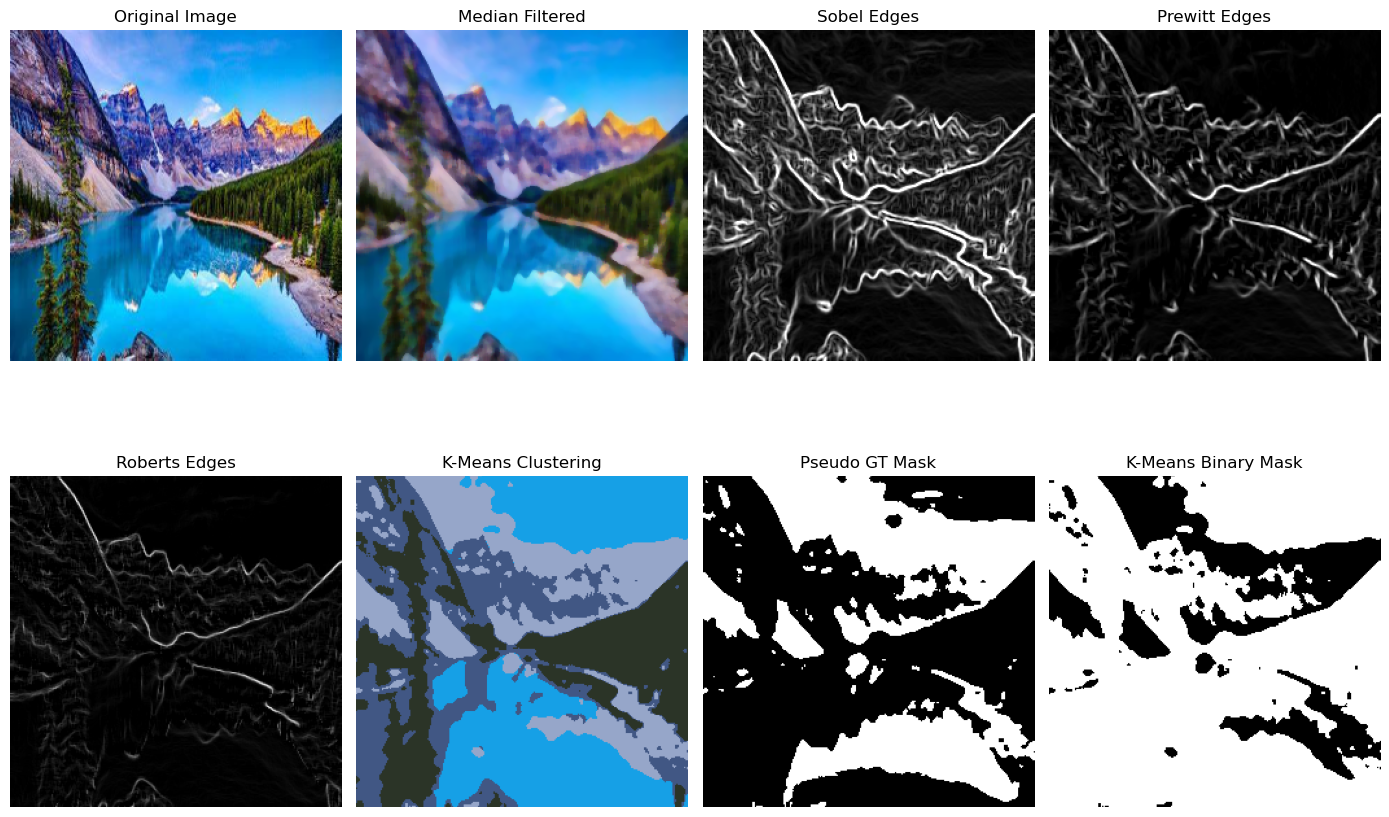


📊 Evaluation Metrics:
✔️ PSNR: 17.48 dB
✔️ Jaccard Index: 0.14
✔️ F1 Score: 0.25
✔️ Execution Time: 1.58 seconds


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score
import time

start_time = time.time()

# ------------------- Load and Resize Image -------------------
img = cv2.imread(r"C:\Users\onlyh\Downloads\nature1.jpeg")  # Update path if needed
img = cv2.resize(img, (256, 256))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_img = img_rgb.copy()

# ------------------- Median Filtering Per Channel -------------------
def median_filter_color(img):
    filtered = np.zeros_like(img)
    for i in range(3):  # R, G, B
        filtered[:, :, i] = cv2.medianBlur(img[:, :, i], 5)
    return filtered

filtered_img = median_filter_color(img_rgb)

# ------------------- Sobel Edge Detection -------------------
gray = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = np.sqrt(sobelx.astype(np.float32)**2 + sobely.astype(np.float32)**2)
edges_sobel = cv2.convertScaleAbs(sobel_mag)

# ------------------- Prewitt Edge Detection -------------------
kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
prewittx = cv2.filter2D(gray, -1, kernelx)
prewitty = cv2.filter2D(gray, -1, kernely)
prewitt_mag = np.sqrt(prewittx.astype(np.float32)**2 + prewitty.astype(np.float32)**2)
edges_prewitt = cv2.convertScaleAbs(prewitt_mag)

# ------------------- Roberts Edge Detection -------------------
robertsx = np.array([[1, 0], [0, -1]])
robertsy = np.array([[0, 1], [-1, 0]])
robertx = cv2.filter2D(gray, -1, robertsx)
roberty = cv2.filter2D(gray, -1, robertsy)
roberts_mag = np.sqrt(robertx.astype(np.float32)**2 + roberty.astype(np.float32)**2)
edges_roberts = cv2.convertScaleAbs(roberts_mag)

# ------------------- Custom K-Means Clustering -------------------
def custom_kmeans(data, k, max_iters=100, tol=1e-4):
    indices = np.random.choice(len(data), k, replace=False)
    centroids = data[indices]

    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([
            data[labels == j].mean(axis=0) if np.any(labels == j) else centroids[j]
            for j in range(k)
        ])

        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return centroids, labels

def kmeans_color_clustering(img, k=4):
    img_data = img.reshape((-1, 3)).astype(np.float32)
    centroids, labels = custom_kmeans(img_data, k)
    clustered_img = centroids[labels].reshape(img.shape).astype(np.uint8)
    return clustered_img, labels.reshape(img.shape[:2])

# Apply clustering
clustered_img, cluster_labels = kmeans_color_clustering(filtered_img, k=4)

# ------------------- PSNR -------------------
def compute_psnr(original, denoised):
    mse = np.mean((original.astype(np.float32) - denoised.astype(np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255.0 / np.sqrt(mse))

psnr_value = compute_psnr(original_img, clustered_img)

# ------------------- Evaluation: Jaccard Index & F1 Score -------------------
_, pseudo_gt = cv2.threshold(gray, 128, 1, cv2.THRESH_BINARY)
pseudo_gt = pseudo_gt.flatten()
pred = (cluster_labels > 0).astype(np.uint8).flatten()

jaccard = jaccard_score(pseudo_gt, pred, average='binary')
fscore = f1_score(pseudo_gt, pred, average='binary')

# ------------------- Execution Time -------------------
exec_time = time.time() - start_time

# ------------------- Plot Results -------------------
plt.figure(figsize=(14, 10))

plt.subplot(2, 4, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(2, 4, 2)
plt.title("Median Filtered")
plt.imshow(filtered_img)
plt.axis('off')

plt.subplot(2, 4, 3)
plt.title("Sobel Edges")
plt.imshow(edges_sobel, cmap='gray')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.title("Prewitt Edges")
plt.imshow(edges_prewitt, cmap='gray')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.title("Roberts Edges")
plt.imshow(edges_roberts, cmap='gray')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.title("K-Means Clustering")
plt.imshow(clustered_img)
plt.axis('off')

plt.subplot(2, 4, 7)
plt.title("Pseudo GT Mask")
plt.imshow(pseudo_gt.reshape(256, 256), cmap='gray')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.title("K-Means Binary Mask")
plt.imshow(pred.reshape(256, 256), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# ------------------- Print Metrics -------------------
print("\n📊 Evaluation Metrics:")
print(f"✔️ PSNR: {psnr_value:.2f} dB")
print(f"✔️ Jaccard Index: {jaccard:.2f}")
print(f"✔️ F1 Score: {fscore:.2f}")
print(f"✔️ Execution Time: {exec_time:.2f} seconds")


In [46]:
#Watershed with region growing


🔍 Resolution: (128, 128)
🟢 Region Growing -> Jaccard: 0.000, Rand: -0.000, Time: 0.01s
🔵 Watershed      -> Jaccard: 0.476, Rand: 0.510, Time: 0.06s


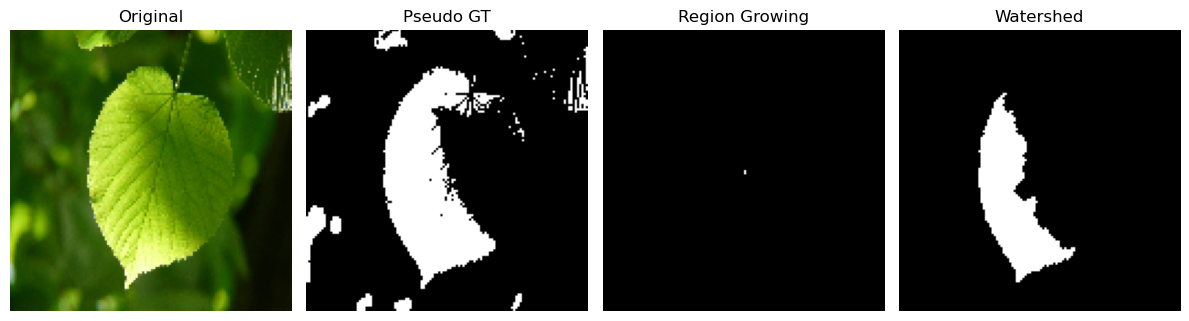


🔍 Resolution: (256, 256)
🟢 Region Growing -> Jaccard: 0.003, Rand: 0.003, Time: 0.00s
🔵 Watershed      -> Jaccard: 0.493, Rand: 0.526, Time: 0.00s


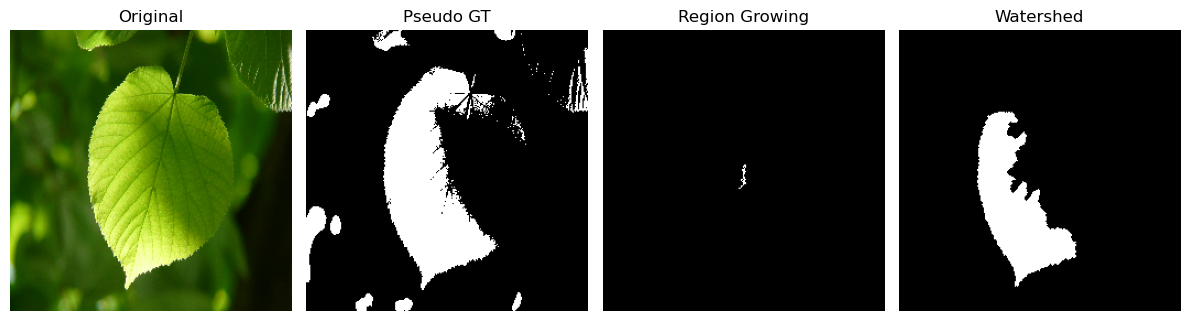


🔍 Resolution: (512, 512)
🟢 Region Growing -> Jaccard: 0.004, Rand: 0.004, Time: 0.01s
🔵 Watershed      -> Jaccard: 0.445, Rand: 0.478, Time: 0.02s


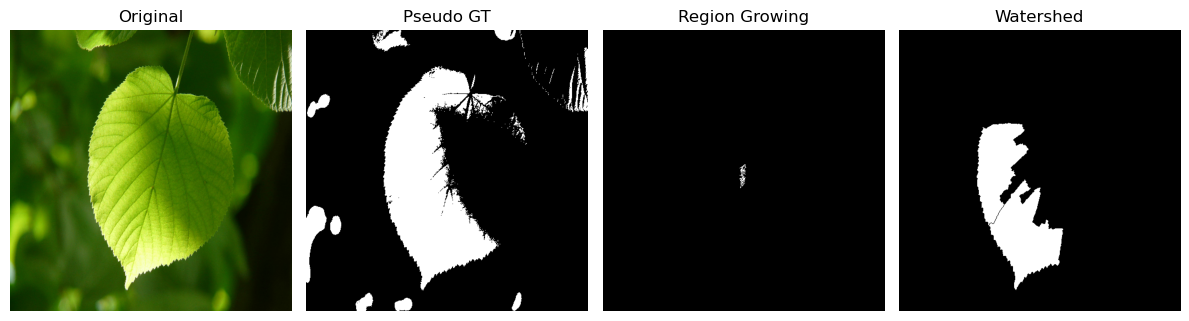

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, adjusted_rand_score
import time

# ----------------- PSNR (Optional) -----------------
def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

# ----------------- Region Growing ------------------
def region_growing(img, seed_point, threshold=5):
    h, w = img.shape
    visited = np.zeros_like(img, dtype=bool)
    region = np.zeros_like(img)
    
    seed_val = img[seed_point]
    stack = [seed_point]
    
    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        visited[x, y] = True
        
        if abs(int(img[x, y]) - int(seed_val)) < threshold:
            region[x, y] = 255
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < h and 0 <= ny < w and not visited[nx, ny]:
                        stack.append((nx, ny))
    return region

# ----------------- Watershed ------------------
def watershed_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    
    img_copy = img.copy()
    cv2.watershed(img_copy, markers)
    segmented = np.where(markers > 1, 255, 0).astype(np.uint8)
    
    return segmented

# ----------------- Evaluation ------------------
def evaluate_segmentation(original, segmented, method_name):
    flat_gt = original.flatten() // 255
    flat_pred = segmented.flatten() // 255
    
    jaccard = jaccard_score(flat_gt, flat_pred)
    rand_index = adjusted_rand_score(flat_gt, flat_pred)
    return jaccard, rand_index

# ----------------- Main Execution ------------------
image_path = r"C:\Users\onlyh\Downloads\leaf1.jpg"
resolutions = [(128, 128), (256, 256), (512, 512)]

for res in resolutions:
    print(f"\n🔍 Resolution: {res}")
    img = cv2.imread(image_path)
    img = cv2.resize(img, res)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    # Generate pseudo ground truth using thresholding
    _, pseudo_gt = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # --- Region Growing ---
    start_rg = time.time()
    seed = (res[1] // 2, res[0] // 2)
    rg_result = region_growing(gray, seed)
    time_rg = time.time() - start_rg

    jaccard_rg, rand_rg = evaluate_segmentation(pseudo_gt, rg_result, "Region Growing")

    # --- Watershed ---
    start_ws = time.time()
    ws_result = watershed_segmentation(img_rgb)
    time_ws = time.time() - start_ws

    jaccard_ws, rand_ws = evaluate_segmentation(pseudo_gt, ws_result, "Watershed")

    # --- Print Metrics ---
    print(f"🟢 Region Growing -> Jaccard: {jaccard_rg:.3f}, Rand: {rand_rg:.3f}, Time: {time_rg:.2f}s")
    print(f"🔵 Watershed      -> Jaccard: {jaccard_ws:.3f}, Rand: {rand_ws:.3f}, Time: {time_ws:.2f}s")

    # --- Show Segmentations ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Pseudo GT")
    plt.imshow(pseudo_gt, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Region Growing")
    plt.imshow(rg_result, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Watershed")
    plt.imshow(ws_result, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
All filters (smoothing filters)

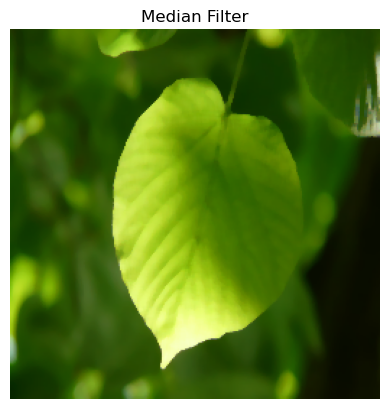

📌 Median Filter Metrics:
   - MSE:   104.03
   - RMSE:  10.20
   - PSNR:  27.96 dB
   - SSIM:  0.8496



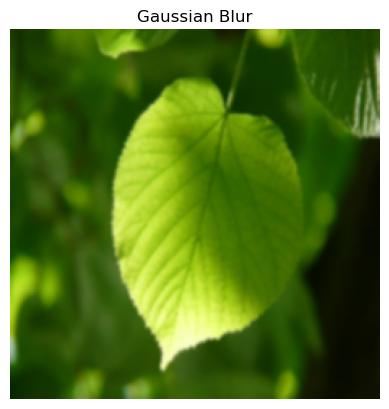

📌 Gaussian Blur Metrics:
   - MSE:   71.39
   - RMSE:  8.45
   - PSNR:  29.59 dB
   - SSIM:  0.8949



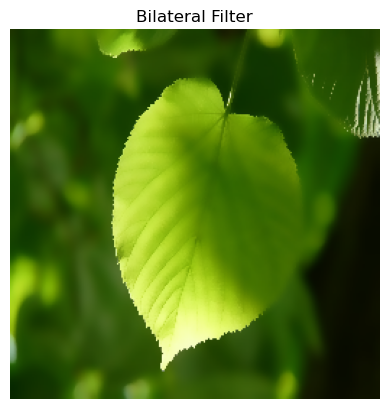

📌 Bilateral Filter Metrics:
   - MSE:   30.57
   - RMSE:  5.53
   - PSNR:  33.28 dB
   - SSIM:  0.8923



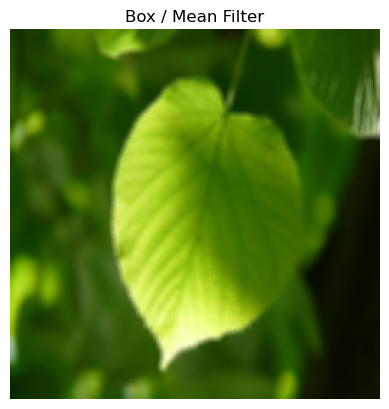

📌 Box / Mean Filter Metrics:
   - MSE:   117.55
   - RMSE:  10.84
   - PSNR:  27.43 dB
   - SSIM:  0.8407



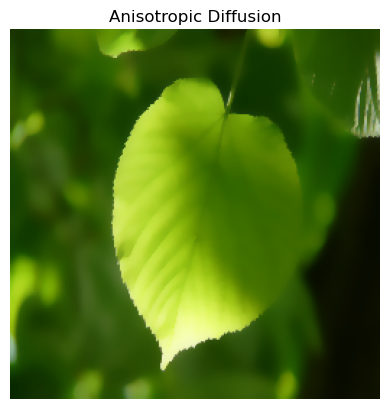

📌 Anisotropic Diffusion Metrics:
   - MSE:   54.60
   - RMSE:  7.39
   - PSNR:  30.76 dB
   - SSIM:  0.8496



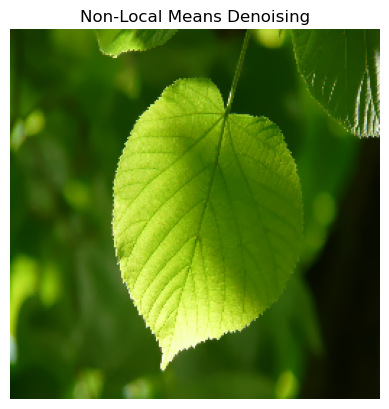

📌 Non-Local Means Denoising Metrics:
   - MSE:   2.16
   - RMSE:  1.47
   - PSNR:  44.78 dB
   - SSIM:  0.9749



In [31]:
# -------------------- IMPORTS --------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import denoise_tv_chambolle, denoise_nl_means, estimate_sigma
import warnings
warnings.filterwarnings("ignore")

# -------------------- LOAD IMAGE --------------------
img_path =r"C:\Users\onlyh\Downloads\leaf1.jpg"  # 🔁 Replace with your image path
img = cv2.imread(img_path)
img = cv2.resize(img, (256, 256))  # Resize for consistency
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# -------------------- METRICS FUNCTION --------------------
def compute_metrics(original, processed):
    original = original.astype(np.float32)
    processed = processed.astype(np.float32)
    mse = np.mean((original - processed) ** 2)
    rmse = np.sqrt(mse)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse != 0 else float('inf')
    ssim_val = ssim(original.astype(np.uint8), processed.astype(np.uint8), channel_axis=-1)
    return mse, rmse, psnr, ssim_val

# -------------------- DISPLAY FUNCTION --------------------
def show_and_evaluate(title, processed_img):
    plt.imshow(processed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    mse, rmse, psnr, ssim_val = compute_metrics(img_rgb, processed_img)
    print(f"📌 {title} Metrics:")
    print(f"   - MSE:   {mse:.2f}")
    print(f"   - RMSE:  {rmse:.2f}")
    print(f"   - PSNR:  {psnr:.2f} dB")
    print(f"   - SSIM:  {ssim_val:.4f}\n")

# -------------------- 1. MEDIAN FILTER --------------------
median = cv2.medianBlur(img_rgb, 5)
show_and_evaluate("Median Filter", median)

# -------------------- 2. GAUSSIAN BLUR --------------------
gaussian = cv2.GaussianBlur(img_rgb, (5, 5), 0)
show_and_evaluate("Gaussian Blur", gaussian)

# -------------------- 3. BILATERAL FILTER --------------------
bilateral = cv2.bilateralFilter(img_rgb, 9, 75, 75)
show_and_evaluate("Bilateral Filter", bilateral)

# -------------------- 4. BOX / MEAN FILTER --------------------
box = cv2.blur(img_rgb, (5, 5))
show_and_evaluate("Box / Mean Filter", box)

# -------------------- 5. ANISOTROPIC DIFFUSION --------------------
img_float = img_rgb.astype(np.float32) / 255.0
anisotropic = denoise_tv_chambolle(img_float, weight=0.1, channel_axis=-1)
anisotropic_uint8 = (anisotropic * 255).astype(np.uint8)
show_and_evaluate("Anisotropic Diffusion", anisotropic_uint8)

# -------------------- 6. NON-LOCAL MEANS --------------------
sigma_est = np.mean(estimate_sigma(img_float, channel_axis=-1))
nl_means = denoise_nl_means(img_float, h=1.15 * sigma_est, fast_mode=True,
                             patch_size=5, patch_distance=3, channel_axis=-1)
nl_means_uint8 = (nl_means * 255).astype(np.uint8)
show_and_evaluate("Non-Local Means Denoising", nl_means_uint8)


In [33]:
#sharpening filters

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.ndimage import convolve
# Load grayscale image
img = cv2.imread(r"C:\Users\onlyh\Downloads\nature1.jpeg" , cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))  # Optional resize
original = img.copy()


In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import precision_score, recall_score, f1_score


In [49]:
def prf_metrics(gt, pred):
    gt = gt.flatten() > 0
    pred = pred.flatten() > 0
    precision = precision_score(gt, pred)
    recall = recall_score(gt, pred)
    f1 = f1_score(gt, pred)
    return precision, recall, f1

def pratt_fom(gt_edges, test_edges, alpha=1/9):
    gt_y, gt_x = np.where(gt_edges > 0)
    test_y, test_x = np.where(test_edges > 0)
    if len(test_x) == 0 or len(gt_x) == 0:
        return 0.0
    fom = 0
    for i in range(len(test_x)):
        distances = np.sqrt((gt_x - test_x[i])**2 + (gt_y - test_y[i])**2)
        d_min = np.min(distances)
        fom += 1 / (1 + alpha * d_min**2)
    return fom / max(len(gt_x), len(test_x))

def edge_preservation_index(original, filtered):
    lap_orig = cv2.Laplacian(original, cv2.CV_64F)
    lap_filt = cv2.Laplacian(filtered, cv2.CV_64F)
    epi = np.sum(np.abs(lap_filt)) / (np.sum(np.abs(lap_orig)) + 1e-8)
    return epi



=== Laplacian ===


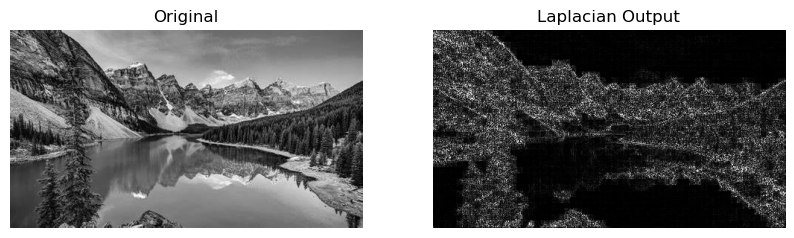

Precision: 0.3453, Recall: 0.3841, F1: 0.3637
Pratt’s FOM: 0.8846
EPI: 2.4818

=== Unsharp Masking ===


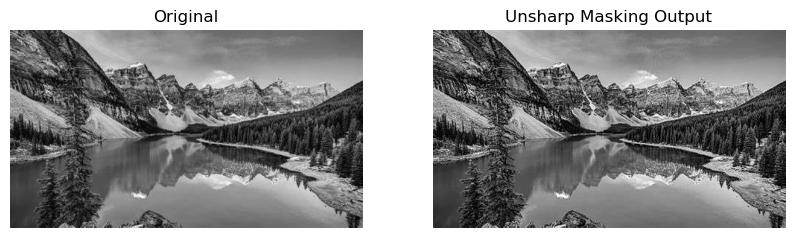

Precision: 0.8500, Recall: 0.9319, F1: 0.8891
Pratt’s FOM: 0.9607
EPI: 1.4325

=== High-Pass FFT ===


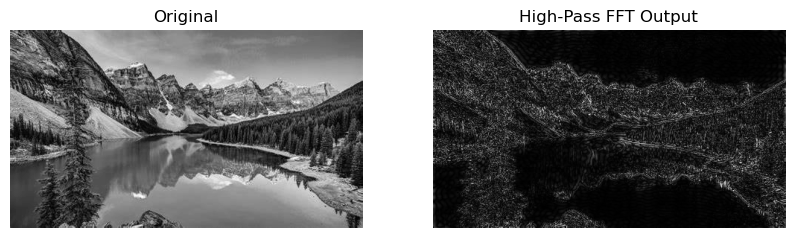

Precision: 0.4225, Recall: 0.4287, F1: 0.4256
Pratt’s FOM: 0.8944
EPI: 1.5580

=== Sobel ===


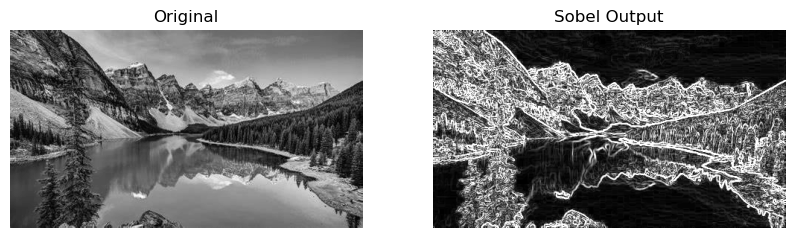

Precision: 0.1976, Recall: 0.2609, F1: 0.2248
Pratt’s FOM: 0.8261
EPI: 3.1326

=== Prewitt ===


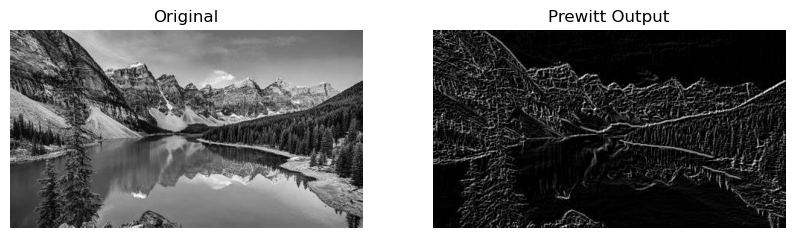

Precision: 0.1896, Recall: 0.2043, F1: 0.1966
Pratt’s FOM: 0.8902
EPI: 1.1329


In [53]:
def apply_laplacian(img):
    return cv2.convertScaleAbs(cv2.Laplacian(img, cv2.CV_64F))

def apply_unsharp(img):
    blurred = cv2.GaussianBlur(img, (5, 5), 1)
    sharp = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)
    return sharp

def apply_highpass_fft(img):
    # Remove color conversion if already grayscale
    img_gray = img.copy()  # Already grayscale

    # FFT
    dft = np.fft.fft2(img_gray)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img_gray.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    r = 30  # Radius of low-frequency area to suppress
    mask[crow - r:crow + r, ccol - r:ccol + r] = 0

    # Apply high-pass filter in frequency domain
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.abs(np.fft.ifft2(f_ishift))

    # Normalize and convert to 8-bit
    return cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


def apply_sobel(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    return cv2.convertScaleAbs(cv2.magnitude(grad_x, grad_y))

def apply_prewitt(img):
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    grad_x = cv2.filter2D(img, -1, kernelx)
    grad_y = cv2.filter2D(img, -1, kernely)
    return cv2.convertScaleAbs(cv2.addWeighted(grad_x, 0.5, grad_y, 0.5, 0))
# Load image
img = cv2.imread(r"C:\Users\onlyh\Downloads\nature1.jpeg")  # Replace with your image
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
original = img.copy()

# Canny edge map as ground truth
canny_orig = cv2.Canny(original, 100, 200)

filters = {
    'Laplacian': apply_laplacian,
    'Unsharp Masking': apply_unsharp,
    'High-Pass FFT': apply_highpass_fft,
    'Sobel': apply_sobel,
    'Prewitt': apply_prewitt,
}

for name, func in filters.items():
    print(f"\n=== {name} ===")
    processed = func(original)

    # Get edges from processed image
    canny_processed = cv2.Canny(processed, 100, 200)

    # Evaluate metrics
    prec, rec, f1 = prf_metrics(canny_orig, canny_processed)
    fom = pratt_fom(canny_orig, canny_processed)
    epi = edge_preservation_index(original, processed)

    # Display
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap='gray')
    plt.title(f"{name} Output")
    plt.axis('off')
    plt.show()

    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print(f"Pratt’s FOM: {fom:.4f}")
    print(f"EPI: {epi:.4f}")


In [55]:
#log and region growing

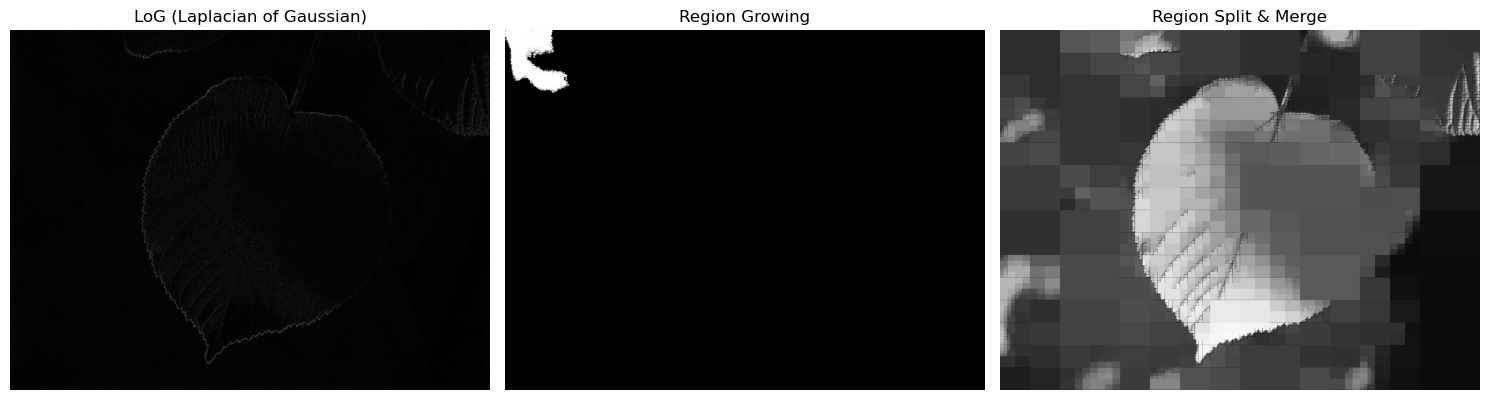

In [56]:
# === Imports ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# === Load Grayscale Image ===
img_path = r"C:\Users\onlyh\Downloads\leaf1.jpg"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# === 1. LoG (Laplacian of Gaussian) ===
def log_edge_detection(gray):
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    log = cv2.Laplacian(blurred, cv2.CV_64F)
    log = np.uint8(np.absolute(log))
    return log

log_img = log_edge_detection(gray)

# === 2. Region Growing ===
def region_grow(img, seed, threshold=5):
    h, w = img.shape
    visited = np.zeros_like(img, dtype=bool)
    region = np.zeros_like(img, dtype=np.uint8)
    seed_value = img[seed]
    queue = deque([seed])

    while queue:
        x, y = queue.popleft()
        if visited[x, y]:
            continue
        visited[x, y] = True

        if abs(int(img[x, y]) - int(seed_value)) <= threshold:
            region[x, y] = 255
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < h and 0 <= ny < w and not visited[nx, ny]:
                        queue.append((nx, ny))
    return region

seed_point = (100, 100)  # Set manually or use cv2.setMouseCallback for GUI
region_img = region_grow(gray, seed_point, threshold=10)

# === 3. Region Splitting and Merging ===
def split(img, x, y, w, h, thresh_std=15):
    region = img[x:x+h, y:y+w]
    if w <= 8 or h <= 8 or np.std(region) < thresh_std:
        return [(x, y, w, h)]
    else:
        w2, h2 = w // 2, h // 2
        return (
            split(img, x, y, w2, h2) +
            split(img, x, y + w2, w2, h2) +
            split(img, x + h2, y, w2, h2) +
            split(img, x + h2, y + w2, w2, h2)
        )

def merge_regions(img, regions):
    merged = np.zeros_like(img)
    for (x, y, w, h) in regions:
        region = img[x:x+h, y:y+w]
        mean_val = int(np.mean(region))
        merged[x:x+h, y:y+w] = mean_val
    return merged

regions = split(gray, 0, 0, gray.shape[1], gray.shape[0])
merged_img = merge_regions(gray, regions)

# === 4. Display Results ===
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(log_img, cmap='gray'); axs[0].set_title("LoG (Laplacian of Gaussian)")
axs[1].imshow(region_img, cmap='gray'); axs[1].set_title("Region Growing")
axs[2].imshow(merged_img, cmap='gray'); axs[2].set_title("Region Split & Merge")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()


In [57]:
#shape based segmentation

Dice Coefficient: 0.9634
Jaccard Index   : 0.9294
Rand Index      : 0.9168
Pixel Accuracy  : 0.9565


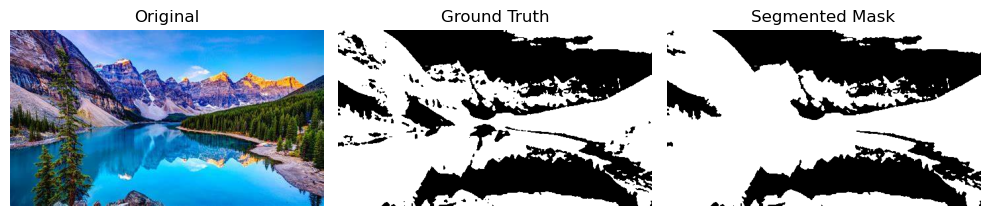

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import rand_score
from skimage.metrics import adapted_rand_error, variation_of_information

# =============================
# Step 1: Load and Preprocess
# =============================
img_path = r"C:\Users\onlyh\Downloads\nature1.jpeg"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV)

# =============================
# Step 2: Shape-Based Segmentation
# =============================
# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create blank mask for segmentation result
segmentation_mask = np.zeros_like(binary)
cv2.drawContours(segmentation_mask, contours, -1, (255), thickness=cv2.FILLED)

# =============================
# Step 3: Ground Truth (Synthetic for demo)
# =============================
# Let's assume thresholded binary is our ground truth for demo
ground_truth = binary.copy()

# =============================
# Step 4: Evaluation Metrics
# =============================
def dice_coefficient(gt, pred):
    gt = gt.flatten() // 255
    pred = pred.flatten() // 255
    intersection = np.sum(gt * pred)
    return 2. * intersection / (np.sum(gt) + np.sum(pred))

def jaccard_index(gt, pred):
    gt = gt.flatten() // 255
    pred = pred.flatten() // 255
    return jaccard_score(gt, pred)

def rand_index(gt, pred):
    gt = gt.flatten() // 255
    pred = pred.flatten() // 255
    return rand_score(gt, pred)

def pixel_accuracy(gt, pred):
    gt = gt.flatten() // 255
    pred = pred.flatten() // 255
    return accuracy_score(gt, pred)

# Compute metrics
dice = dice_coefficient(ground_truth, segmentation_mask)
jaccard = jaccard_index(ground_truth, segmentation_mask)
rand = rand_index(ground_truth, segmentation_mask)
accuracy = pixel_accuracy(ground_truth, segmentation_mask)

# =============================
# Step 5: Display and Output
# =============================
print(f"Dice Coefficient: {dice:.4f}")
print(f"Jaccard Index   : {jaccard:.4f}")
print(f"Rand Index      : {rand:.4f}")
print(f"Pixel Accuracy  : {accuracy:.4f}")

# Show images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Segmented Mask")
plt.imshow(segmentation_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
